# IND6212 Project
---

# Preprocessing

In [1]:
# import libraries
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from keras import metrics
from keras import callbacks
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model

Using TensorFlow backend.


In [2]:
# if runned on colaboratory
GOOGLE = False
if GOOGLE:
    # Load the Drive helper and mount
    from google.colab import drive
    drive.mount("/content/drive/")
    path = "/content/drive/My Drive/EPM/PhD/IND6212/Projet/"
else:
    path = ""

In [3]:
# read intakes
with open("{}data/aac_intakes.csv".format(path), "r") as file:
    reader = csv.reader(file)
    header_intake = next(reader)
    intakes = [[value for value in row] for row in reader]

In [4]:
# read outcomes
with open("{}data/aac_outcomes.csv".format(path), "r") as file:
    reader = csv.reader(file)
    header_outcome = next(reader)
    outcomes = [[value for value in row] for row in reader]

In [5]:
# convert numpy array
header_intake = np.asarray(header_intake)
header_outcome = np.asarray(header_outcome)

intakes = np.asarray(intakes)
outcomes = np.asarray(outcomes)

In [6]:
print("Intakes")
for i, c in enumerate(header_intake):
    print("{} : {}".format(i, c))

Intakes
0 : age_upon_intake
1 : animal_id
2 : animal_type
3 : breed
4 : color
5 : datetime
6 : datetime2
7 : found_location
8 : intake_condition
9 : intake_type
10 : name
11 : sex_upon_intake


In [7]:
print("Outcomes")
for i, c in enumerate(header_outcome):
    print("{} : {}".format(i, c))

Outcomes
0 : age_upon_outcome
1 : animal_id
2 : animal_type
3 : breed
4 : color
5 : date_of_birth
6 : datetime
7 : monthyear
8 : name
9 : outcome_subtype
10 : outcome_type
11 : sex_upon_outcome


In [8]:
# get the last outcome (it can be transfered multiple times, we want the last update)
# if no outcome, then we remove the example (line)
counter = 0
data = []
for i, x in enumerate(intakes, 1):
    index = np.where(outcomes[:, 1] == x[1])
    if len(index[0]) > 0 and outcomes[index[0][-1], 10]:
        data.append(np.concatenate((x, [outcomes[index[0][-1], 10]])))
    else:
        counter += 1
    print("\r{} | {}".format(i - counter, counter), end=" ")

79776 | 411                                                                                                                                                                                                                                                                                                                                                                                                                

In [9]:
# add the outcome to data
data = np.asarray(data)
header = np.concatenate((header_intake, ["outcome"]))

The author of the dataset explained that Rto-Adopt = Return to Owner and Disposal = Died (see [link](https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/discussion/56707#latest-329163))

In [10]:
for row in data:
    if row[-1] == "Rto-Adopt":
        row[-1]="Return to Owner"
    if row[-1] == "Disposal":
        row[-1]="Died"

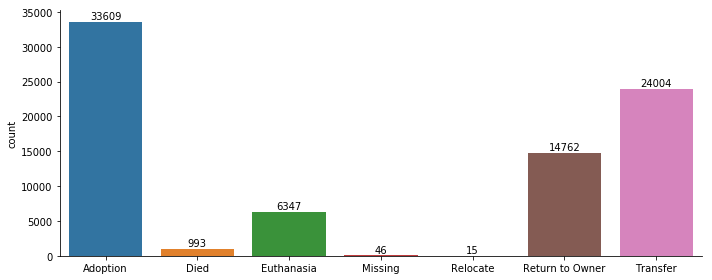

In [11]:
# plot class distribution with seaborn
plt.figure(figsize=(10, 4))
name, count = np.unique(data[:, -1], return_counts=True)
graph = sns.countplot(data[:, -1], order=name)
for i, c in enumerate(count):
    graph.text(i, c + max(count) * 0.01, c, ha="center")
sns.despine()
plt.tight_layout()
plt.savefig("figures/class_distribution.png", dpi=300, transparent=True)
plt.show()
plt.close()

In [12]:
# remove the animal id
data = np.delete(data, 1, axis=1)
header = np.delete(header, 1, axis=0)

In [13]:
# convert intake date into a real value (year)
for x in data:
    s = x[0].split()
    if "year" in s[1]:
        x[0] = float(s[0])
    if "month" in s[1]:
        x[0] = float(s[0]) / 12.
    if "week" in s[1]:
        x[0] = float(s[0]) / 52.
    if "day" in s[1]:
        x[0] = float(s[0]) / 365.

In [14]:
# convertir animal breed to integer
mapping_breed, breed_int = np.unique(data[:, 2], return_inverse=True)
data = np.delete(data, [1, 2], axis=1)
header = np.delete(header, [1, 2], axis=0)
data = np.concatenate((data, breed_int.reshape(-1, 1)), axis=1)
header = np.concatenate((header, ["animal_breed"]))

In [15]:
# convert color to integer
mapping_color, color_int = np.unique(data[:, 1], return_inverse=True)
data = np.delete(data, 1, axis=1)
header = np.delete(header, 1, axis=0)
data = np.concatenate((data, color_int.reshape(-1, 1)), axis=1)
header = np.concatenate((header, ["color"]))

In [16]:
# remove location
data = np.delete(data, 3, axis=1)
header = np.delete(header, 3, axis=0)

In [17]:
# check if datetime and datetime2 are identical
if np.array_equal(data[:, 1], data[:, 2]):
    print("Datetime duplicated")
else:
    print("Datetime not duplicated")

Datetime duplicated


In [18]:
# remove datetime2
data = np.delete(data, 2, axis=1)
header = np.delete(header, 2, axis=0)

In [19]:
# convert condition to integer
mapping_condition, condition_int = np.unique(data[:, 2], return_inverse=True)
data = np.delete(data, 2, axis=1)
header = np.delete(header, 2, axis=0)
data = np.concatenate((data, condition_int.reshape(-1, 1)), axis=1)
header = np.concatenate((header, ["condition"]))

In [20]:
# convert type to integer
mapping_type, type_int = np.unique(data[:, 2], return_inverse=True)
data = np.delete(data, 2, axis=1)
header = np.delete(header, 2, axis=0)
data = np.concatenate((data, type_int.reshape(-1, 1)), axis=1)
header = np.concatenate((header, ["type"]))

In [21]:
# check if name as any impact
out = list(set(data[:, 4]))
out_name = [0 for _ in out]
out_noname = [0 for _ in out]

for d in data:
    if d[2]:
        out_name[out.index(d[4])] += 1
    else:
        out_noname[out.index(d[4])] += 1
print("{:20s} | {:^15s} | {:^15s}".format("Outcome", "with name",
                                          "without name"))
print("-" * 56)
for a, b, c in zip(out, out_name, out_noname):
    print("{:20s} | {:^15.2%} | {:^15.2%}".format(a, b / np.sum(out_name),
                                                  c / np.sum(out_noname)))

Outcome              |    with name    |  without name  
--------------------------------------------------------
Missing              |      0.06%      |      0.04%     
Died                 |      0.45%      |      3.05%     
Adoption             |     50.43%      |     23.37%     
Relocate             |      0.00%      |      0.06%     
Return to Owner      |     25.85%      |      1.91%     
Transfer             |     20.55%      |     51.64%     
Euthanasia           |      2.66%      |     19.92%     


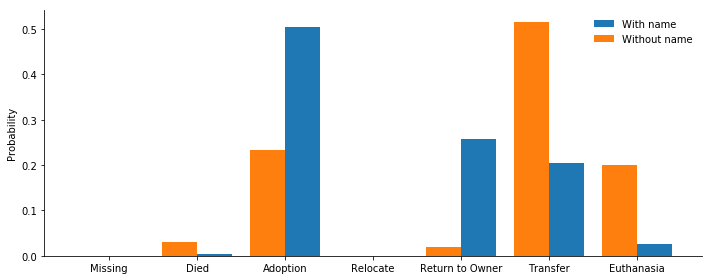

In [22]:
# plot class distribution with seaborn
plt.figure(figsize=(10, 4))
plt.bar(
    out,
    out_name / np.sum(out_name),
    width=0.4,
    align="edge",
    label="With name")
plt.bar(
    out,
    out_noname / np.sum(out_noname),
    width=-0.4,
    align="edge",
    label="Without name")
plt.legend(frameon=False)
plt.ylabel("Probability")
sns.despine()
plt.tight_layout()
plt.savefig("figures/sex_distribution.png", dpi=300, transparent=True)
plt.show()
plt.close()

In [23]:
# the presence of a name seems to have an impact on the outcome
# its value should not have any effect (difficult to evaluate)
# replace absence of a name by 0 and presence of a name by 1
for row in data:
    row[2] = 1 if row[2] else 0

Intact Female        :  23739 ( 29.8%)
Intact Male          :  25355 ( 31.8%)
NULL                 :      1 (  0.0%)
Neutered Male        :  12728 ( 16.0%)
Spayed Female        :  11168 ( 14.0%)
Unknown              :   6785 (  8.5%)


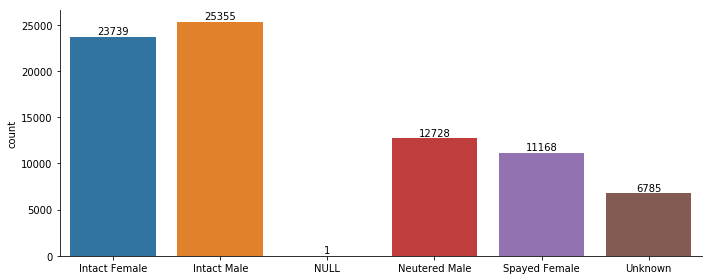

In [24]:
# sex analysis
sex, count = np.unique(data[:, 3], return_counts=True)
for s, c in zip(sex, count):
    print("{:20s} : {:6d} ({:6.1%})".format(s, c, c / data.shape[0]))
    
# plot class distribution with seaborn
plt.figure(figsize=(10, 4))
graph = sns.countplot(data[:, 3], order=sex)
for i, c in enumerate(count):
    graph.text(i, c + max(count) * 0.01, c, ha="center")
sns.despine()
plt.tight_layout()
plt.savefig("figures/sex_distribution.png", dpi=300, transparent=True)
plt.show()
plt.close()

In [25]:
# check if name as any impact
out = list(set(data[:, 4]))
sex = list(set(data[:, 3]))
table = [[0 for _ in out] for _ in sex]
for d in data:
    table[sex.index(d[3])][out.index(d[4])] += 1

print(" " * 14, end="")
for o in out:
    print("{:^14s}".format(o), end="")
print("")
for i, s in zip(table, sex):
    print("{:^14s}".format(s), end="")
    for j in i:
        print("{:^14d}".format(j), end="")
    print("")

                 Missing         Died        Adoption      Relocate   Return to Owner   Transfer     Euthanasia  
   Unknown          2            476            70            14            84           2747          3392     
 Intact Male        18           255          12178           0            3523          8282          1099     
Neutered Male       3             42           4699           0            4958          2429          597      
Spayed Female       4             48           4690           0            3950          2099          377      
Intact Female       19           172          11972           1            2246          8447          882      
     NULL           0             0             0             0             1             0             0       


In [26]:
# we cannot remove unknown because it seems to have an impact on the outcome (extremly low adoption rate)
# there is only one NULL, which is suspect, we\"ll remove this
id = np.where(data[:, 3] == "NULL")[0][0]
data = np.delete(data, id, axis=0)

In [27]:
# convert sex to integer
mapping_sex, sex_int = np.unique(data[:, 3], return_inverse=True)
data = np.delete(data, 3, axis=1)
header = np.delete(header, 3, axis=0)
data = np.concatenate((data, sex_int.reshape(-1, 1)), axis=1)
header = np.concatenate((header, ["sex"]))

In [28]:
# keep only month for datetime
mapping_sex, sex_int = np.unique(data[:, 3], return_inverse=True)
for d in data:
    d[1] = int(d[1].split("-")[1])

In [29]:
# put labels (outcomes) in separate matrix
mapping_outcome, labels = np.unique(data[:, 3], return_inverse=True)
x = np.delete(data, 3, axis=1)
header = np.delete(header, 3, axis=0)

In [30]:
x = x.astype("float32")
labels = labels.astype("int")

In [31]:
for i, (row, label) in enumerate(zip(x, labels)):
    for h, value in zip(header, row):
        print("{:20s} : {}".format(h, value))
    print("\tOutcome: {}".format(label))
    print("-----------------------")
    if i > 2:
        break

age_upon_intake      : 8.0
datetime             : 7.0
name                 : 1.0
animal_breed         : 1007.0
color                : 498.0
condition            : 3.0
type                 : 3.0
sex                  : 3.0
	Outcome: 5
-----------------------
age_upon_intake      : 0.9166666865348816
datetime             : 4.0
name                 : 1.0
animal_breed         : 231.0
color                : 382.0
condition            : 3.0
type                 : 3.0
sex                  : 1.0
	Outcome: 5
-----------------------
age_upon_intake      : 0.07692307978868484
datetime             : 10.0
name                 : 0.0
animal_breed         : 952.0
color                : 194.0
condition            : 7.0
type                 : 3.0
sex                  : 0.0
	Outcome: 6
-----------------------
age_upon_intake      : 4.0
datetime             : 6.0
name                 : 1.0
animal_breed         : 924.0
color                : 415.0
condition            : 3.0
type                 : 3.0
sex   

In [32]:
# convert outcomes (y) to one_hot
y = np.eye(len(set(labels)))[labels]

In [33]:
print("Nb attributes: {}".format(x.shape[1]))
print("Nb different outcomes: {}".format(len(set(labels))))

Nb attributes: 8
Nb different outcomes: 7


# Models

In [34]:
# function to compute and plot the confusion matrix
def cfm(true, pred, mapping, name):
    cond_true = (len(true.shape) == 1) or (true.shape[1] == 1)
    true = true < 0.5 if cond_true else np.argmax(true, axis=1)

    cond_pred = (len(pred.shape) == 1) or (pred.shape[1] == 1)
    pred = pred < 0.5 if cond_pred else np.argmax(pred, axis=1)

    plt.figure()
    plt.gca().set_axis_off()
    plt.table(
        cellText=confusion_matrix(true, pred),
        rowLabels=mapping,
        colLabels=mapping,
        loc="center")

    plt.tight_layout()
    plt.savefig("figures/cfm_{}.png".format(name), dpi=300, transparent=True)
    plt.show()
    plt.close()

In [35]:
# function to plot the learning graphs
def plot_history(history, name):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # summarize history for accuracy
    axes[0].plot(history.history["acc"])
    axes[0].plot(history.history["val_acc"])
    axes[0].set_ylabel("Accuracy (%)")
    axes[0].set_xlabel("Epoch")

    axes[0].legend(["Train", "Validation"], title="Set", frameon=False)
    # summarize history for loss
    axes[1].plot(history.history["loss"])
    axes[1].plot(history.history["val_loss"])
    axes[1].set_ylabel("Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].legend(["Train", "Validation"], title="Set", frameon=False)

    sns.despine()
    plt.tight_layout()
    plt.savefig("figures/history_{}.png".format(name), dpi=300, transparent=True)
    plt.show()
    plt.close()

In [36]:
#normalize x
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [37]:
# split dataset into a training, validation and test set
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y, test_size=0.2, stratify=y)
# we split first (train/test) then (train/valid) 12.5% of 80% is the same as 10% of 100%
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.125, stratify=y_train)

In [38]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(55842, 8)
(7978, 8)
(15955, 8)


In [39]:
input = Input(shape=(8, ))
dense = BatchNormalization()(input)
dense = Dense(256)(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
dense = Activation("relu")(dense)
dense = Dense(128)(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
dense = Activation("relu")(dense)
dense = Dense(64)(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
dense = Activation("relu")(dense)
dense = Dense(7)(dense)
output = Activation("softmax")(dense)

model = Model(inputs=input, outputs=output)

model.compile(
    loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2304      
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation_1 (Activat

In [40]:
history = model.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=9999,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[
        callbacks.EarlyStopping(
            monitor="val_acc",
            min_delta=0.0001,
            patience=25,
            restore_best_weights=True)
    ])

Instructions for updating:
Use tf.cast instead.
Train on 55842 samples, validate on 7978 samples
Epoch 1/9999
55842/55842 [==============================] - 6s 114us/step - loss: 1.4408 - acc: 0.4553 - val_loss: 1.0785 - val_acc: 0.5648
Epoch 2/9999
55842/55842 [==============================] - 2s 39us/step - loss: 1.1345 - acc: 0.5382 - val_loss: 0.9990 - val_acc: 0.5920
Epoch 3/9999
55842/55842 [==============================] - 2s 39us/step - loss: 1.0676 - acc: 0.5609 - val_loss: 0.9723 - val_acc: 0.6020
Epoch 4/9999
55842/55842 [==============================] - 2s 39us/step - loss: 1.0385 - acc: 0.5748 - val_loss: 0.9592 - val_acc: 0.6062
Epoch 5/9999
55842/55842 [==============================] - 2s 39us/step - loss: 1.0183 - acc: 0.5861 - val_loss: 0.9514 - val_acc: 0.6122
Epoch 6/9999
55842/55842 [==============================] - 2s 39us/step - loss: 1.0052 - acc: 0.5917 - val_loss: 0.9476 - val_acc: 0.6137
Epoch 7/9999
55842/55842 [==============================] - 2s 39us/

55842/55842 [==============================] - 2s 39us/step - loss: 0.9247 - acc: 0.6261 - val_loss: 0.8936 - val_acc: 0.6270
Epoch 58/9999
55842/55842 [==============================] - 2s 40us/step - loss: 0.9231 - acc: 0.6259 - val_loss: 0.8933 - val_acc: 0.6280
Epoch 59/9999
55842/55842 [==============================] - 2s 40us/step - loss: 0.9215 - acc: 0.6270 - val_loss: 0.8931 - val_acc: 0.6289
Epoch 60/9999
55842/55842 [==============================] - 2s 40us/step - loss: 0.9222 - acc: 0.6263 - val_loss: 0.8921 - val_acc: 0.6274
Epoch 61/9999
55842/55842 [==============================] - 2s 40us/step - loss: 0.9223 - acc: 0.6256 - val_loss: 0.8926 - val_acc: 0.6287
Epoch 62/9999
55842/55842 [==============================] - 2s 39us/step - loss: 0.9226 - acc: 0.6250 - val_loss: 0.8918 - val_acc: 0.6280
Epoch 63/9999
55842/55842 [==============================] - 2s 40us/step - loss: 0.9205 - acc: 0.6262 - val_loss: 0.8923 - val_acc: 0.6285
Epoch 64/9999
55842/55842 [=======

55842/55842 [==============================] - 2s 39us/step - loss: 0.9109 - acc: 0.6301 - val_loss: 0.8830 - val_acc: 0.6307
Epoch 116/9999
55842/55842 [==============================] - 2s 40us/step - loss: 0.9113 - acc: 0.6293 - val_loss: 0.8841 - val_acc: 0.6311
Epoch 117/9999
55842/55842 [==============================] - 2s 40us/step - loss: 0.9096 - acc: 0.6301 - val_loss: 0.8839 - val_acc: 0.6310
Epoch 118/9999
55842/55842 [==============================] - 2s 39us/step - loss: 0.9096 - acc: 0.6297 - val_loss: 0.8836 - val_acc: 0.6314
Epoch 119/9999
55842/55842 [==============================] - 2s 40us/step - loss: 0.9105 - acc: 0.6299 - val_loss: 0.8850 - val_acc: 0.6307
Epoch 120/9999
55842/55842 [==============================] - 2s 40us/step - loss: 0.9112 - acc: 0.6300 - val_loss: 0.8832 - val_acc: 0.6289
Epoch 121/9999
55842/55842 [==============================] - 2s 39us/step - loss: 0.9108 - acc: 0.6317 - val_loss: 0.8824 - val_acc: 0.6296
Epoch 122/9999
55842/55842 [

In [41]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.8761320245038077
Test accuracy: 0.6412409902739696


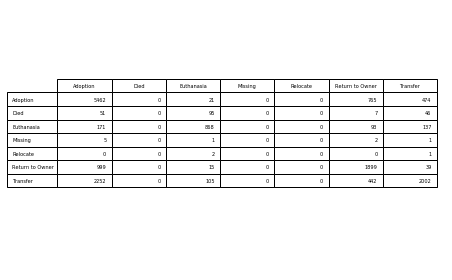

In [42]:
cfm(y_test, model.predict(x_test), mapping_outcome, "discret_multiclasse")

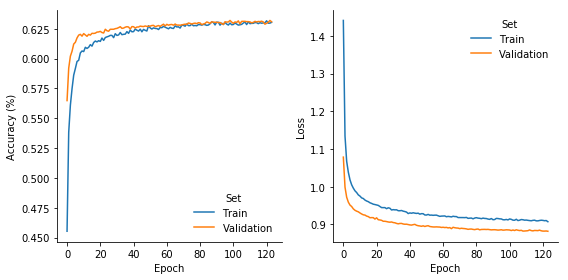

In [43]:
plot_history(history, "discret_multiclasse")

In [44]:
# not accurate enough, let"s only check if the animal is adopted
binary_y = np.asarray([int(label[0] == 1) for label in y])
# split dataset into a training, validation and test set
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, binary_y, test_size=0.2, stratify=binary_y)
# we split first (train/test) then (train/valid) 12.5% of 80% is the same as 10% of 100%
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.125, stratify=y_train)

In [45]:
input = Input(shape=(8, ))
dense = BatchNormalization()(input)
dense = Dense(256)(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
dense = Activation("relu")(dense)
dense = Dense(128)(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
dense = Activation("relu")(dense)
dense = Dense(64)(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
dense = Activation("relu")(dense)
dense = Dense(32)(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
dense = Activation("relu")(dense)
dense = Dense(1)(dense)
output = Activation("sigmoid")(dense)

model = Model(inputs=input, outputs=output)

model.compile(
    loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8)                 32        
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2304      
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
__________

In [46]:
key, value = np.unique(y_train, return_counts=True)
class_weight = dict(zip(key, max(value) / value))
print(class_weight)

{0: 1.0, 1: 1.3736291762305535}


In [47]:
history = model.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=9999,
    verbose=1,
#     class_weight=class_weight,
    validation_data=(x_val, y_val),
    callbacks=[
        callbacks.EarlyStopping(
            monitor="val_acc",
            min_delta=0.001,
            patience=10,
            restore_best_weights=True)
    ])

Train on 55842 samples, validate on 7978 samples
Epoch 1/9999
55842/55842 [==============================] - 5s 86us/step - loss: 0.6865 - acc: 0.5854 - val_loss: 0.5985 - val_acc: 0.6504
Epoch 2/9999
55842/55842 [==============================] - 3s 47us/step - loss: 0.6227 - acc: 0.6299 - val_loss: 0.5889 - val_acc: 0.6718
Epoch 3/9999
55842/55842 [==============================] - 3s 47us/step - loss: 0.6089 - acc: 0.6503 - val_loss: 0.5832 - val_acc: 0.6800
Epoch 4/9999
55842/55842 [==============================] - 3s 47us/step - loss: 0.6016 - acc: 0.6656 - val_loss: 0.5795 - val_acc: 0.6821
Epoch 5/9999
55842/55842 [==============================] - 3s 47us/step - loss: 0.5945 - acc: 0.6726 - val_loss: 0.5758 - val_acc: 0.6886
Epoch 6/9999
55842/55842 [==============================] - 3s 46us/step - loss: 0.5909 - acc: 0.6794 - val_loss: 0.5722 - val_acc: 0.6928
Epoch 7/9999
55842/55842 [==============================] - 3s 45us/step - loss: 0.5890 - acc: 0.6829 - val_loss: 0.5

In [48]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.549864679324668
Test accuracy: 0.7024757129762734


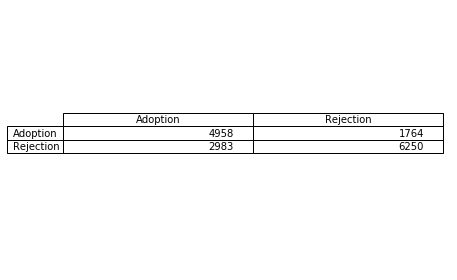

In [49]:
cfm(y_test, model.predict(x_test), ["Adoption", "Rejection"], "discret_binaire")

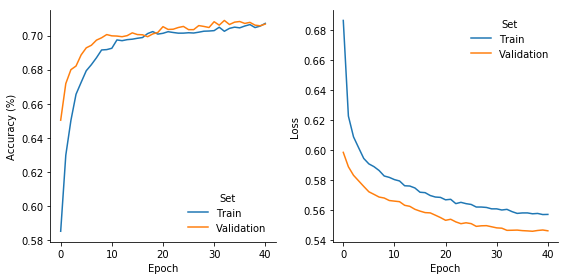

In [50]:
plot_history(history, "discret_binaire")

In [51]:
# Let"s try with one hot vector input (except age, data which are real valued -> scaled version, and name that is arleady binary)
one_hot_animal_breed = np.eye(len(set(x[:, 3])))[x[:, 3].astype("int")]
one_hot_color = np.eye(len(set(x[:, 4])))[x[:, 4].astype("int")]
one_hot_condition = np.eye(len(set(x[:, 5])))[x[:, 5].astype("int")]
one_hot_type = np.eye(len(set(x[:, 6])))[x[:, 6].astype("int")]
one_hot_sex = np.eye(len(set(x[:, 7])))[x[:, 7].astype("int")]

x_one_hot = np.concatenate(
    (x_scaled[:, :2], x[:, 2].reshape(-1, 1), one_hot_animal_breed,
     one_hot_color, one_hot_condition, one_hot_type, one_hot_sex),
    axis=1)

In [52]:
# split dataset into a training, validation and test set
x_train, x_test, y_train, y_test = train_test_split(
    x_one_hot, binary_y, test_size=0.2, stratify=binary_y)
# we split first (train/test) then (train/valid) 12.5% of 80% is the same as 10% of 100%
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.125, stratify=y_train)

In [53]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(55842, 2709)
(7978, 2709)
(15955, 2709)


In [54]:
input = Input(shape=(2709, ))
dense = BatchNormalization()(input)
dense = Dense(128)(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.75)(dense)
dense = Activation("relu")(dense)
dense = Dense(64)(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.75)(dense)
dense = Activation("relu")(dense)
dense = Dense(32)(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.75)(dense)
dense = Activation("relu")(dense)
dense = Dense(1)(dense)
output = Activation("sigmoid")(dense)

model = Model(inputs=input, outputs=output)

model.compile(
    loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2709)              0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 2709)              10836     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               346880    
_________________________________________________________________
batch_normalization_11 (Batc (None, 128)               512       
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_10 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
__________

In [55]:
key, value = np.unique(y_train, return_counts=True)
class_weight = dict(zip(key, max(value) / value))
print(class_weight)

{0: 1.0, 1: 1.3736291762305535}


In [56]:
history = model.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=9999,
    verbose=1,
#     class_weight=class_weight,
    validation_data=(x_val, y_val),
    callbacks=[
        callbacks.EarlyStopping(
            monitor="val_acc",
            min_delta=0.001,
            patience=10,
            restore_best_weights=True)
    ])

Train on 55842 samples, validate on 7978 samples
Epoch 1/9999
55842/55842 [==============================] - 6s 109us/step - loss: 0.8609 - acc: 0.5198 - val_loss: 0.6726 - val_acc: 0.5800
Epoch 2/9999
55842/55842 [==============================] - 4s 72us/step - loss: 0.7315 - acc: 0.5459 - val_loss: 0.6609 - val_acc: 0.5819
Epoch 3/9999
55842/55842 [==============================] - 4s 64us/step - loss: 0.6801 - acc: 0.5687 - val_loss: 0.6407 - val_acc: 0.5926
Epoch 4/9999
55842/55842 [==============================] - 4s 66us/step - loss: 0.6542 - acc: 0.5895 - val_loss: 0.6172 - val_acc: 0.6465
Epoch 5/9999
55842/55842 [==============================] - 5s 83us/step - loss: 0.6305 - acc: 0.6105 - val_loss: 0.5964 - val_acc: 0.6477
Epoch 6/9999
55842/55842 [==============================] - 4s 80us/step - loss: 0.6163 - acc: 0.6257 - val_loss: 0.5847 - val_acc: 0.6613
Epoch 7/9999
55842/55842 [==============================] - 4s 78us/step - loss: 0.6049 - acc: 0.6424 - val_loss: 0.

In [57]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.568720673474351
Test accuracy: 0.7220933876340945


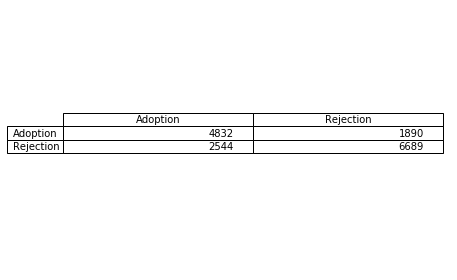

In [58]:
cfm(y_test, model.predict(x_test), ["Adoption", "Rejection"],
    "one_hot_binaire")

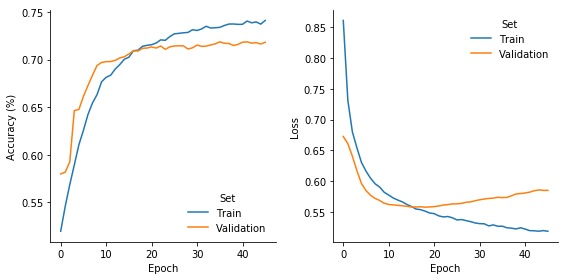

In [59]:
plot_history(history, "one_hot_binaire")